# Stock Price Prediction Model

## Dependencies

### Library Installation (if needed)

In [93]:
#! pip install -Ur requirements.txt

### Importing Required Libraries

In [94]:
import matplotlib.pyplot as plt
import yfinance as yf
import pandas as pd
import numpy as np
import pickle
import gradio as gr
import ast
import requests
import warnings
from methods.model_methods import *
from datetime import datetime
from tqdm import tqdm
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=SyntaxWarning)

### Variables

In [95]:
symbol_list = input("Symbols: ('simple', 'filtered' or 'all')") # 'simple' or 'all'. simple are the tickers from the screener notebook and all are all of the tickers in 'filtered_tickers'. You may also an 'Int' to get a % amount of random tickers from 'all'
if symbol_list:
    build_new_dataset = True
else:
    build_new_dataset = False
    symbol_list = 'filtered'
max_nan_in_row = 0.8 # if nan_amount > max_nan_in_row*len(columns) then remove that column
outlier = 3
train_new_model = {'True': True, 'False': False}.get(input('Train new models? (Bool)'))
debugging = {'True': True, 'False': False}.get(input('Debug? (Bool)'))

### Select symbols for training

In [96]:
symbols = pd.read_csv('../data/tickers/simple_tickers.csv')['Ticker'].tolist()
if symbol_list == 'filtered':
    symbols = symbols + pd.read_csv('../data/tickers/model_filtered_tickers.csv')['Ticker'].tolist()
elif symbol_list == 'all':
    symbols = symbols + pd.read_csv('../data/tickers/tickers.csv')['Ticker'].tolist()
elif symbol_list.isdigit():
    all_symbols = pd.read_csv('../data/tickers/tickers.csv')['Ticker'].tolist()
    num_symbols = max(1, round(len(all_symbols) * (int(symbol_list) / 100)))  
    symbols = symbols + pd.read_csv("../data/tickers/model_filtered_tickers.csv")["Ticker"].tolist()
    symbols = symbols + np.random.choice(all_symbols, num_symbols, replace=False).tolist()
symbols = pd.Series(symbols).unique()

## Data Preparation

#### Test load

In [97]:
if debugging:
    test_stock = Stock("LLY").get_df_financials()
    display(test_stock)

,Ticker,Name,Date,Earn Index,Sector,Industry,Price,3M Future Change,TaxEffectOfUnusualItems,TaxRateForCalcs,...,Receivables,OtherReceivables,AccountsReceivable,AllowanceForDoubtfulAccountsReceivable,GrossAccountsReceivable,CashCashEquivalentsAndShortTermInvestments,OtherShortTermInvestments,CashAndCashEquivalents,CashEquivalents,CashFinancial
0,LLY,Eli Lilly and Company,2025-09-30,0,Healthcare,Drug Manufacturers - General,763.000000,NaN,-2.221265e+08,0.228126,...,1.945720e+10,3.349800e+09,1.610740e+10,-21700000.0,1.612910e+10,9.913500e+09,121600000.0,9.791900e+09,NaN,NaN
1,LLY,Eli Lilly and Company,2025-06-30,1,Healthcare,Drug Manufacturers - General,777.821594,-0.065968,-6.554043e+06,0.164674,...,1.720560e+10,3.035200e+09,1.417040e+10,-16100000.0,1.418650e+10,3.546000e+09,170100000.0,3.375900e+09,NaN,NaN
2,LLY,Eli Lilly and Company,2025-03-31,2,Healthcare,Drug Manufacturers - General,822.414185,-0.054222,-3.541868e+08,0.202000,...,1.400320e+10,1.966600e+09,1.203660e+10,-15500000.0,1.205210e+10,3.220700e+09,127400000.0,3.093300e+09,NaN,NaN
3,LLY,Eli Lilly and Company,2024-12-31,3,Healthcare,Drug Manufacturers - General,767.409729,0.044842,-6.914325e+08,0.165000,...,1.327540e+10,2.269700e+09,1.100570e+10,-14900000.0,1.102060e+10,3.423200e+09,154800000.0,3.268400e+09,NaN,NaN
4,LLY,Eli Lilly and Company,2024-09-30,4,Healthcare,Drug Manufacturers - General,879.216125,-0.125086,-1.087488e+09,0.389000,...,1.205170e+10,1.756900e+09,1.029480e+10,-15700000.0,1.031050e+10,3.518400e+09,149400000.0,3.369000e+09,NaN,NaN
5,LLY,Eli Lilly and Company,2023-12-31,5,Healthcare,Drug Manufacturers - General,573.652222,0.341695,-7.814277e+08,0.201000,...,1.133620e+10,2.245700e+09,9.090500e+09,-14800000.0,9.105300e+09,2.927700e+09,109100000.0,2.818600e+09,1.088400e+09,1.730200e+09
6,LLY,Eli Lilly and Company,2022-12-31,6,Healthcare,Drug Manufacturers - General,357.777649,-0.058246,-1.297954e+08,0.083000,...,8.558900e+09,1.662900e+09,6.896000e+09,-16000000.0,6.912000e+09,2.211800e+09,144800000.0,2.067000e+09,6.574000e+08,1.409600e+09
7,LLY,Eli Lilly and Company,2021-12-31,7,Healthcare,Drug Manufacturers - General,266.490448,0.063977,-1.408485e+08,0.093000,...,8.127200e+09,1.454400e+09,6.672800e+09,-22500000.0,6.695300e+09,3.908600e+09,90100000.0,3.818500e+09,2.379500e+09,1.439000e+09


#### Download annual financial data

In [98]:
if build_new_dataset:
    df = pd.DataFrame()
    filtered_pd = pd.read_csv("../data/tickers/model_filtered_tickers.csv")
    for symbol in tqdm(symbols, smoothing=0):
        ticker_df = pd.DataFrame()
        ticker = yf.Ticker(symbol)
        stock = Stock(symbol)
        try:
            ticker_df = Stock(symbol).get_df_financials()
            for i in range(len(ticker_df)):
                if ticker_df.loc[i].isna().sum() > len(ticker_df.columns)*max_nan_in_row:
                    ticker_df = ticker_df.drop(i)
                imputer = SimpleImputer()
                for column in ticker_df.columns.drop(["Ticker", "Name", "Date", "Price", "3M Future Change", "Sector", "Industry"]):
                    if not ticker_df[column].isna().all():
                        ticker_df[column] = imputer.fit_transform(ticker_df[[column]])
            df = pd.concat([df, ticker_df], ignore_index=True)
        except Exception as error:
            if symbol in filtered_pd["Ticker"].tolist():
                filtered_pd = filtered_pd[filtered_pd["Ticker"] != symbol]
                if debugging:
                    print(f"Removed {symbol} from filtered tickers because an exception was raised: \n {error}")
            else:
                if debugging:
                    print(f"{symbol}: exception raised: {error}")
            continue
    filtered_pd.to_csv("../data/tickers/model_filtered_tickers.csv", index=False)
    df.to_csv("../data/model_results/earnings_data.csv", index=False)
else:
    df = pd.read_csv("../data/model_results/earnings_data.csv")

### Short visualisation

In [99]:
if debugging:
    display(df)

,Ticker,Name,Date,Earn Index,Sector,Industry,Price,3M Future Change,TaxEffectOfUnusualItems,TaxRateForCalcs,...,PolicyholderBenefitsGross,PolicyholderBenefitsCeded,DepletionIncomeStatement,CurrentDeferredTaxesAssets,OccupancyAndEquipment,ProfessionalExpenseAndContractServicesExpense,OtherNonInterestExpense,SecuritiesAmortization,ExciseTaxes,RestrictedCommonStock
0,MATAS.CO,Matas A/S,2025-09-30,0.0,Consumer Cyclical,Specialty Retail,130.000000,NaN,-2.483871e+06,0.225806,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,MATAS.CO,Matas A/S,2025-06-30,1.0,Consumer Cyclical,Specialty Retail,133.399994,-0.025487,-1.097561e+06,0.219512,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,MATAS.CO,Matas A/S,2025-03-31,2.0,Consumer Cyclical,Specialty Retail,130.047333,0.025780,-7.209000e+06,0.267000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,MATAS.CO,Matas A/S,2024-12-31,3.0,Consumer Cyclical,Specialty Retail,133.397034,-0.025111,-2.443609e+05,0.244361,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,MATAS.CO,Matas A/S,2024-09-30,4.0,Consumer Cyclical,Specialty Retail,122.756798,0.086677,1.129032e+06,0.225806,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4543,MLI,"Mueller Industries, Inc.",2024-12-31,3.0,Industrials,Metal Fabrication,78.647705,-0.020053,1.989750e+06,0.250000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4544,MLI,"Mueller Industries, Inc.",2024-09-30,4.0,Industrials,Metal Fabrication,73.248833,0.079253,6.511300e+05,0.230000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4545,MLI,"Mueller Industries, Inc.",2023-12-31,5.0,Industrials,Metal Fabrication,46.711731,0.133794,1.742018e+07,0.261000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4546,MLI,"Mueller Industries, Inc.",2022-12-31,6.0,Industrials,Metal Fabrication,28.405334,0.250705,-9.712950e+05,0.255000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Impution and encoding

In [100]:
imputer = SimpleImputer()
for column in df.columns.drop(["Ticker", "Name", "Date", "Earn Index", "Price", "3M Future Change", "Sector", "Industry"]):
    df[column] = imputer.fit_transform(df[[column]])

le = LabelEncoder()
for column in ["Ticker", "Sector", "Industry"]:
    df[column] = df[column].astype(str)
    le.fit(df[column])
    df[column] = le.transform(df[column])

### Feature engineering

C:\Users\Gamer\AppData\Local\Temp\ipykernel_12640\872096102.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["PE"] = df["Price"]/(df["BasicEPS"])


,Ticker,Name,Date,Earn Index,Sector,Industry,Price,3M Future Change,TaxEffectOfUnusualItems,TaxRateForCalcs,...,PolicyholderBenefitsCeded,DepletionIncomeStatement,CurrentDeferredTaxesAssets,OccupancyAndEquipment,ProfessionalExpenseAndContractServicesExpense,OtherNonInterestExpense,SecuritiesAmortization,ExciseTaxes,RestrictedCommonStock,PE
0,373,Matas A/S,2025-09-30,0.0,2,108,130.000000,NaN,-2.483871e+06,0.225806,...,1.295544e+09,292600000.0,8.465556e+07,7.256330e+08,3.434661e+08,1.417478e+10,534447.916667,2.307808e+09,7314000.0,203.125000
1,373,Matas A/S,2025-06-30,1.0,2,108,133.399994,-0.025487,-1.097561e+06,0.219512,...,1.295544e+09,292600000.0,8.465556e+07,7.256330e+08,3.434661e+08,1.417478e+10,534447.916667,2.307808e+09,7314000.0,79.880236
2,373,Matas A/S,2025-03-31,2.0,2,108,130.047333,0.025780,-7.209000e+06,0.267000,...,1.295544e+09,292600000.0,8.465556e+07,7.256330e+08,3.434661e+08,1.417478e+10,534447.916667,2.307808e+09,7314000.0,17.526595
3,373,Matas A/S,2024-12-31,3.0,2,108,133.397034,-0.025111,-2.443609e+05,0.244361,...,1.295544e+09,292600000.0,8.465556e+07,7.256330e+08,3.434661e+08,1.417478e+10,534447.916667,2.307808e+09,7314000.0,25.169252
4,373,Matas A/S,2024-09-30,4.0,2,108,122.756798,0.086677,1.129032e+06,0.225806,...,1.295544e+09,292600000.0,8.465556e+07,7.256330e+08,3.434661e+08,1.417478e+10,534447.916667,2.307808e+09,7314000.0,191.807497
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4543,388,"Mueller Industries, Inc.",2024-12-31,3.0,7,68,78.647705,-0.020053,1.989750e+06,0.250000,...,1.295544e+09,292600000.0,8.465556e+07,7.256330e+08,3.434661e+08,1.417478e+10,534447.916667,2.307808e+09,7314000.0,14.483924
4544,388,"Mueller Industries, Inc.",2024-09-30,4.0,7,68,73.248833,0.079253,6.511300e+05,0.230000,...,1.295544e+09,292600000.0,8.465556e+07,7.256330e+08,3.434661e+08,1.417478e+10,534447.916667,2.307808e+09,7314000.0,48.509161
4545,388,"Mueller Industries, Inc.",2023-12-31,5.0,7,68,46.711731,0.133794,1.742018e+07,0.261000,...,1.295544e+09,292600000.0,8.465556e+07,7.256330e+08,3.434661e+08,1.417478e+10,534447.916667,2.307808e+09,7314000.0,8.634331
4546,388,"Mueller Industries, Inc.",2022-12-31,6.0,7,68,28.405334,0.250705,-9.712950e+05,0.255000,...,1.295544e+09,292600000.0,8.465556e+07,7.256330e+08,3.434661e+08,1.417478e+10,534447.916667,2.307808e+09,7314000.0,4.814463


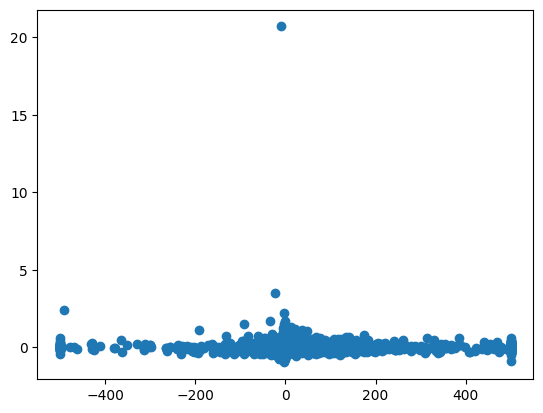

In [101]:
df["PE"] = df["Price"]/(df["BasicEPS"])
pe_limit = 500
df["PE"] = df["PE"].apply(lambda x: pe_limit if x > pe_limit else x)
df["PE"] = df["PE"].apply(lambda x: -pe_limit if x < -pe_limit else x)
if debugging:
    display(df)
    plt.scatter(df["PE"].to_list(), df["3M Future Change"].to_list())
    plt.show()

### Scaling

In [102]:
scaler = StandardScaler()
for column in df.columns.drop(["Ticker", "Name", "Date", "Earn Index", "Price", "3M Future Change", "Sector", "Industry"]):
    scaler.fit(df[[column]])
    df[column] = scaler.transform(df[[column]])

### Splitting

In [103]:
pred_data = df.loc[df["Earn Index"] == 0].copy()
test_data  = df.loc[df["Earn Index"] == 1].copy()
train_data = df.loc[~df["Earn Index"].isin([0, 1])].copy()

pred_data.reset_index(drop=True, inplace=True)
test_data.reset_index(drop=True, inplace=True)
train_data.reset_index(drop=True, inplace=True)

if debugging:
    print('Prediction Data:')
    display(pred_data)
    print("Test Data:")
    display(test_data)
    print('Training Data:')
    display(train_data)

Prediction Data:


,Ticker,Name,Date,Earn Index,Sector,Industry,Price,3M Future Change,TaxEffectOfUnusualItems,TaxRateForCalcs,...,PolicyholderBenefitsCeded,DepletionIncomeStatement,CurrentDeferredTaxesAssets,OccupancyAndEquipment,ProfessionalExpenseAndContractServicesExpense,OtherNonInterestExpense,SecuritiesAmortization,ExciseTaxes,RestrictedCommonStock,PE
0,373,Matas A/S,2025-09-30,0.0,2,108,130.000000,NaN,0.014289,0.404513,...,0.0,0.0,-4.621448e-15,-8.607360e-17,1.219727e-16,-4.770202e-17,0.0,2.488354e-15,0.0,1.189888
1,612,Trifork Group AG,2025-06-30,0.0,9,51,93.500000,NaN,0.014381,-1.260652,...,0.0,0.0,-4.621448e-15,-8.607360e-17,1.219727e-16,-4.770202e-17,0.0,2.488354e-15,0.0,-4.248753
2,533,RHEINMETALL AG I,2025-09-30,0.0,7,1,1988.500000,NaN,0.014382,1.241151,...,0.0,0.0,-4.621448e-15,-8.607360e-17,1.219727e-16,-4.770202e-17,0.0,2.488354e-15,0.0,3.486203
3,548,SAAB AB ser. B,2025-06-30,0.0,7,1,526.669800,NaN,0.014382,0.315995,...,0.0,0.0,-4.621448e-15,-8.607360e-17,1.219727e-16,-4.770202e-17,0.0,2.488354e-15,0.0,1.048117
4,56,BAE Systems PLC,2024-12-31,0.0,7,1,56.118683,NaN,0.014287,-0.137187,...,0.0,0.0,-4.621448e-15,-8.607360e-17,1.219727e-16,-4.770202e-17,0.0,2.488354e-15,0.0,-0.214065
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
668,392,"Maximus, Inc.",2025-06-30,0.0,7,105,69.950737,NaN,0.014382,0.797063,...,0.0,0.0,-4.621448e-15,-8.607360e-17,1.219727e-16,-4.770202e-17,0.0,2.488354e-15,0.0,-0.091935
669,377,"Marchex, Inc.",2025-06-30,0.0,1,0,2.190000,NaN,0.014382,-1.608855,...,0.0,0.0,-4.621448e-15,-8.607360e-17,1.219727e-16,-4.770202e-17,0.0,2.488354e-15,0.0,3.486203
670,442,Norfolk Southern Corporation,2025-09-30,0.0,7,90,298.972382,NaN,0.013594,0.465937,...,0.0,0.0,-4.621448e-15,-8.607360e-17,1.219727e-16,-4.770202e-17,0.0,2.488354e-15,0.0,0.348546
671,416,National Bank Holdings Corporat,2025-09-30,0.0,5,11,38.639999,NaN,0.014382,-0.113535,...,0.0,0.0,-4.621448e-15,-5.149934e-01,-6.962073e-01,-3.542838e-01,0.0,2.488354e-15,0.0,-0.056407


Test Data:


,Ticker,Name,Date,Earn Index,Sector,Industry,Price,3M Future Change,TaxEffectOfUnusualItems,TaxRateForCalcs,...,PolicyholderBenefitsCeded,DepletionIncomeStatement,CurrentDeferredTaxesAssets,OccupancyAndEquipment,ProfessionalExpenseAndContractServicesExpense,OtherNonInterestExpense,SecuritiesAmortization,ExciseTaxes,RestrictedCommonStock,PE
0,373,Matas A/S,2025-06-30,1.0,2,108,133.399994,-0.025487,0.014341,0.330080,...,0.0,0.0,-4.621448e-15,-8.607360e-17,1.219727e-16,-4.770202e-17,0.0,2.488354e-15,0.0,0.236595
1,612,Trifork Group AG,2025-03-31,1.0,9,51,84.099998,0.111772,0.014381,1.814095,...,0.0,0.0,-4.621448e-15,-8.607360e-17,1.219727e-16,-4.770202e-17,0.0,2.488354e-15,0.0,3.486203
2,533,RHEINMETALL AG I,2025-06-30,1.0,7,1,1797.000000,0.106566,0.014382,0.583120,...,0.0,0.0,-4.621448e-15,-8.607360e-17,1.219727e-16,-4.770202e-17,0.0,2.488354e-15,0.0,3.486203
3,548,SAAB AB ser. B,2025-03-31,1.0,7,1,391.998016,0.343552,0.014382,0.217592,...,0.0,0.0,-4.621448e-15,-8.607360e-17,1.219727e-16,-4.770202e-17,0.0,2.488354e-15,0.0,0.898087
4,56,BAE Systems PLC,2023-12-31,1.0,7,1,54.674278,0.216240,0.012296,-0.018927,...,0.0,0.0,-4.621448e-15,-8.607360e-17,1.219727e-16,-4.770202e-17,0.0,2.488354e-15,0.0,-0.208802
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
665,392,"Maximus, Inc.",2025-03-31,1.0,7,105,67.676117,0.033610,0.014382,0.938975,...,0.0,0.0,-4.621448e-15,-8.607360e-17,1.219727e-16,-4.770202e-17,0.0,2.488354e-15,0.0,-0.073350
666,377,"Marchex, Inc.",2025-03-31,1.0,1,0,1.630000,0.343558,0.014382,0.217592,...,0.0,0.0,-4.621448e-15,-8.607360e-17,1.219727e-16,-4.770202e-17,0.0,2.488354e-15,0.0,-0.633434
667,442,Norfolk Southern Corporation,2025-06-30,1.0,7,90,253.507980,0.176240,0.013899,0.454111,...,0.0,0.0,-4.621448e-15,-8.607360e-17,1.219727e-16,-4.770202e-17,0.0,2.488354e-15,0.0,0.192216
668,416,National Bank Holdings Corporat,2025-06-30,1.0,5,11,37.322243,0.049508,0.014382,-0.124639,...,0.0,0.0,-4.621448e-15,-5.171212e-01,-6.994181e-01,-3.542831e-01,0.0,2.488354e-15,0.0,-0.056909


Training Data:


,Ticker,Name,Date,Earn Index,Sector,Industry,Price,3M Future Change,TaxEffectOfUnusualItems,TaxRateForCalcs,...,PolicyholderBenefitsCeded,DepletionIncomeStatement,CurrentDeferredTaxesAssets,OccupancyAndEquipment,ProfessionalExpenseAndContractServicesExpense,OtherNonInterestExpense,SecuritiesAmortization,ExciseTaxes,RestrictedCommonStock,PE
0,373,Matas A/S,2025-03-31,2.0,2,108,130.047333,0.025780,0.014112,0.891671,...,0.0,0.0,-4.621448e-15,-8.607360e-17,1.219727e-16,-4.770202e-17,0.0,2.488354e-15,0.0,-0.245707
1,373,Matas A/S,2024-12-31,3.0,2,108,133.397034,-0.025111,0.014373,0.623943,...,0.0,0.0,-4.621448e-15,-8.607360e-17,1.219727e-16,-4.770202e-17,0.0,2.488354e-15,0.0,-0.186592
2,373,Matas A/S,2024-09-30,4.0,2,108,122.756798,0.086677,0.014424,0.404513,...,0.0,0.0,-4.621448e-15,-8.607360e-17,1.219727e-16,-4.770202e-17,0.0,2.488354e-15,0.0,1.102348
3,373,Matas A/S,2024-03-31,5.0,2,108,113.376465,0.006267,0.013165,1.501275,...,0.0,0.0,-4.621448e-15,-8.607360e-17,1.219727e-16,-4.770202e-17,0.0,2.488354e-15,0.0,-0.184205
4,373,Matas A/S,2023-03-31,6.0,2,108,79.810799,0.221444,0.014280,0.655152,...,0.0,0.0,-4.621448e-15,-8.607360e-17,1.219727e-16,-4.770202e-17,0.0,2.488354e-15,0.0,-0.297964
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3200,388,"Mueller Industries, Inc.",2024-12-31,3.0,7,68,78.647705,-0.020053,0.014456,0.690630,...,0.0,0.0,-4.621448e-15,-8.607360e-17,1.219727e-16,-4.770202e-17,0.0,2.488354e-15,0.0,-0.269242
3201,388,"Mueller Industries, Inc.",2024-09-30,4.0,7,68,73.248833,0.079253,0.014406,0.454111,...,0.0,0.0,-4.621448e-15,-8.607360e-17,1.219727e-16,-4.770202e-17,0.0,2.488354e-15,0.0,-0.006059
3202,388,"Mueller Industries, Inc.",2023-12-31,5.0,7,68,46.711731,0.133794,0.015034,0.820715,...,0.0,0.0,-4.621448e-15,-8.607360e-17,1.219727e-16,-4.770202e-17,0.0,2.488354e-15,0.0,-0.314489
3203,388,"Mueller Industries, Inc.",2022-12-31,6.0,7,68,28.405334,0.250705,0.014345,0.749759,...,0.0,0.0,-4.621448e-15,-8.607360e-17,1.219727e-16,-4.770202e-17,0.0,2.488354e-15,0.0,-0.344035


### Labeling

In [104]:
training_columns = ["Ticker", "Earn Index", "Sector", "Industry", "PE"]
label_columns = ["3M Future Change"]
X_pred = pred_data[training_columns]
X_test = test_data[training_columns]
y_test = test_data[label_columns]
X_train = train_data[training_columns]
y_train = train_data[label_columns]
if debugging:
    print("X_pred:")
    display(X_pred)
    print("X_test:")
    display(X_test)
    print("y_test:")
    display(y_test)
    print("X_train:")
    display(X_train)
    print("y_train:")
    display(y_train)

X_pred:


,Ticker,Earn Index,Sector,Industry,PE
0,373,0.0,2,108,1.189888
1,612,0.0,9,51,-4.248753
2,533,0.0,7,1,3.486203
3,548,0.0,7,1,1.048117
4,56,0.0,7,1,-0.214065
...,...,...,...,...,...
668,392,0.0,7,105,-0.091935
669,377,0.0,1,0,3.486203
670,442,0.0,7,90,0.348546
671,416,0.0,5,11,-0.056407


X_test:


,Ticker,Earn Index,Sector,Industry,PE
0,373,1.0,2,108,0.236595
1,612,1.0,9,51,3.486203
2,533,1.0,7,1,3.486203
3,548,1.0,7,1,0.898087
4,56,1.0,7,1,-0.208802
...,...,...,...,...,...
665,392,1.0,7,105,-0.073350
666,377,1.0,1,0,-0.633434
667,442,1.0,7,90,0.192216
668,416,1.0,5,11,-0.056909


y_test:


,3M Future Change
0,-0.025487
1,0.111772
2,0.106566
3,0.343552
4,0.216240
...,...
665,0.033610
666,0.343558
667,0.176240
668,0.049508


X_train:


,Ticker,Earn Index,Sector,Industry,PE
0,373,2.0,2,108,-0.245707
1,373,3.0,2,108,-0.186592
2,373,4.0,2,108,1.102348
3,373,5.0,2,108,-0.184205
4,373,6.0,2,108,-0.297964
...,...,...,...,...,...
3200,388,3.0,7,68,-0.269242
3201,388,4.0,7,68,-0.006059
3202,388,5.0,7,68,-0.314489
3203,388,6.0,7,68,-0.344035


y_train:


,3M Future Change
0,0.025780
1,-0.025111
2,0.086677
3,0.006267
4,0.221444
...,...
3200,-0.020053
3201,0.079253
3202,0.133794
3203,0.250705


## Model Training

In [105]:
if train_new_model:
    predictions = []

    model = RandomForestRegressor(
        n_estimators=500,
        verbose=True
    )
    model.fit(X_train, y_train.values.ravel())
    predictions.append(model.predict(X_test))

    model = MLPRegressor(
        hidden_layer_sizes=(500, 500),
        n_iter_no_change=30,
        learning_rate="adaptive",
        activation="tanh",
        early_stopping=True,
        verbose=True
    )
    model.fit(X_train, y_train.values.ravel())
    predictions.append(model.predict(X_test))

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    2.1s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    4.8s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s


Iteration 1, loss = 2.95988907
Validation score: -0.553228
Iteration 2, loss = 0.33570583
Validation score: -5.920020
Iteration 3, loss = 0.14705534
Validation score: -0.179160
Iteration 4, loss = 0.10571071
Validation score: -0.290400
Iteration 5, loss = 0.09894814
Validation score: -0.130136
Iteration 6, loss = 0.09518519
Validation score: 0.007568
Iteration 7, loss = 0.09445495
Validation score: -0.020422
Iteration 8, loss = 0.09429129
Validation score: -0.027473
Iteration 9, loss = 0.09470505
Validation score: -0.035068
Iteration 10, loss = 0.09439847
Validation score: 0.010637
Iteration 11, loss = 0.09416435
Validation score: 0.007403
Iteration 12, loss = 0.09452704
Validation score: 0.004452
Iteration 13, loss = 0.09446003
Validation score: -0.001003
Iteration 14, loss = 0.09407485
Validation score: -0.057355
Iteration 15, loss = 0.09422652
Validation score: 0.003824
Iteration 16, loss = 0.09398627
Validation score: -0.028440
Iteration 17, loss = 0.09422897
Validation score: -0.0

## Testing and benchmarking

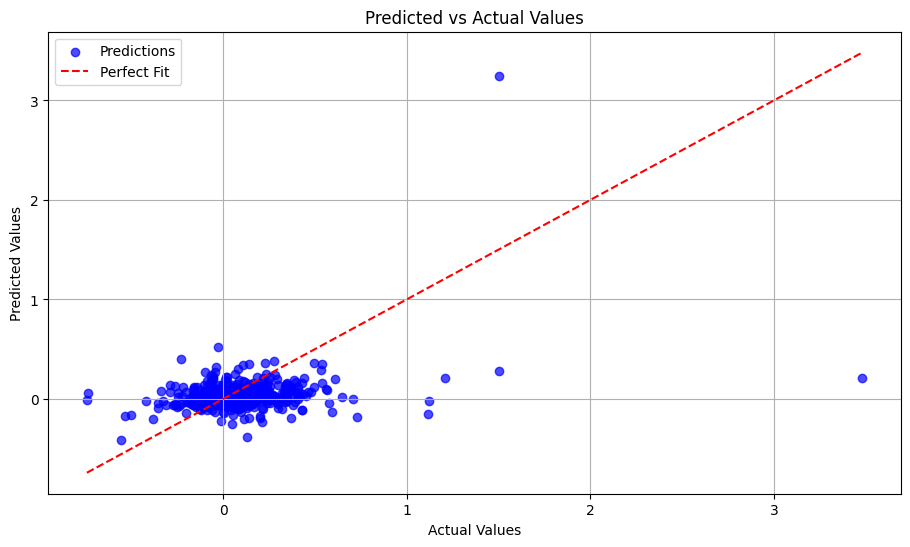

R²: -0.0485
MSE: 0.0606
MAE: 0.1404


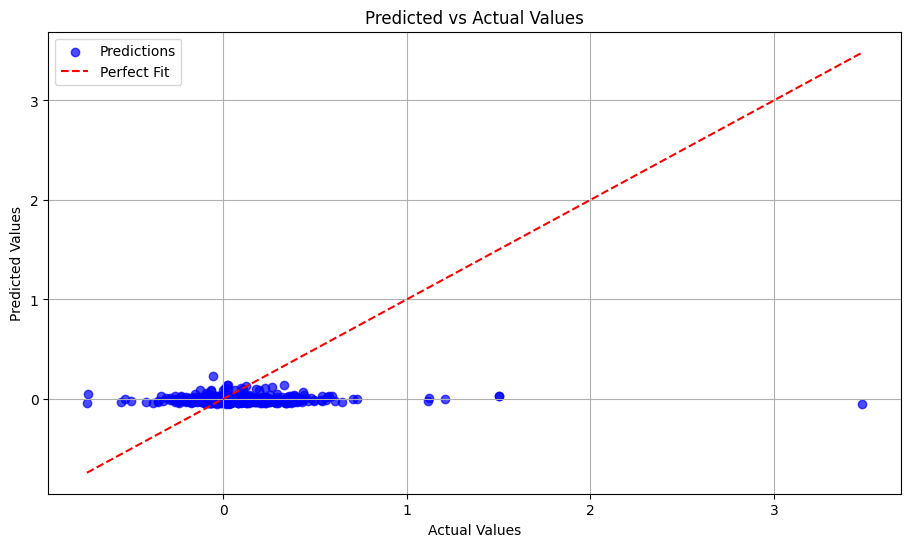

R²: -0.1138
MSE: 0.0644
MAE: 0.1432


In [109]:
if train_new_model:
    for y_pred in predictions:
        plt.figure(figsize=(11, 6))
        plt.scatter(y_test, y_pred, alpha=0.7, color='blue', label='Predictions')
        plt.plot([y_test.values.min(), y_test.values.max()], [y_test.values.min(), y_test.values.max()], 
            color='red', linestyle='--', label='Perfect Fit')
        plt.title(f'Predicted vs Actual Values')
        plt.xlabel('Actual Values')
        plt.ylabel('Predicted Values')
        plt.legend()
        plt.grid(True)
        plt.show()

        mae = mean_absolute_error(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        print(f'R²: {r2:.4f}')
        print(f'MSE: {mse:.4f}')
        print(f'MAE: {mae:.4f}')

### Log test results

In [107]:
if train_new_model:
    test_results = pd.DataFrame({
        'R²': r2,
        'MSE': mse,
        'MAE': mae,
        'symbol_list': symbol_list,
        "iterations": iterations,
        'hidden_layer_sizes': [model.model.hidden_layer_sizes],
        'max_iter': model.model.max_iter,
        'n_iter_no_change': model.model.n_iter_no_change,
        'learning_rate': model.model.learning_rate,
        'learning_rate_init': model.model.learning_rate_init,
        'batch_size': model.model.batch_size,
        'tol': model.model.tol,
        'alpha': model.model.alpha,
        'shuffle': model.model.shuffle,
    })
    test_results.to_csv('../data/model_results/test_results.csv', mode='a', index=False)

    # save model as new best if results are better than the current one
    best_r2 = pd.read_csv('../data/model_results/best_model_results.csv').loc[0, 'R²']
    if r2 > best_r2:
        print(f'Old best R²: {best_r2}')
        print(f'New best R²: {r2}')
        print('Saving new best model...')
        test_results.to_csv('../data/model_results/best_model_results.csv', mode='w', index=False)
        with open('../models/best_model.pkl','wb') as f:
            pickle.dump(model,f)
        

NameError: name 'iterations' is not defined

## Predictions on latest data

In [ ]:
best_r2 = pd.read_csv('../data/model_results/best_model_results.csv').loc[0, 'R²']

with open('../models/best_model.pkl', 'rb') as f:
    model = pickle.load(f)
    print(f'Best model R²: {best_r2}')


FileNotFoundError: [Errno 2] No such file or directory: '../models/best_model.pkl'

In [ ]:
df_raw = pd.read_csv('../data/model_results/earnings_data.csv')

results = []
for i in range(len(X_pred)):
    y_pred = model.predict(X_pred.iloc[[i]])[0]
    y_pred_3m, y_pred_6m, y_pred_9m, y_pred_1y = y_pred
    avg = (y_pred_3m + y_pred_6m + y_pred_9m + y_pred_1y) / 4
    results.append({
        'Ticker': df_raw.loc[i*4, 'Ticker'],
        'Name': df_raw.loc[i*4, 'Name'],
        'mean (%)': avg * 100,
        '3m (%)': y_pred_3m * 100,
        '6m (%)': y_pred_6m * 100,
        '9m (%)': y_pred_9m * 100,
        '1y (%)': y_pred_1y * 100
    })

results_df = pd.DataFrame(results)
results_df

ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- Industry
- PE
- Sector
Feature names seen at fit time, yet now missing:
- Amortization
- AmortizationOfIntangiblesIncomeStatement
- AverageDilutionEarnings
- BasicAverageShares
- BasicEPS
- ...


In [ ]:
def predict_ticker(ticker_str):
    try:
        ticker_str = str(ticker_str).upper()
        ticker_str = ticker_str.replace("'", "")
        ticker_str = ticker_str.replace('"', "")
        row = results_df[results_df['Ticker'] == ticker_str]
        if row.empty:
            return (f"Not enough data for this stock at this moment \n Try another", "", "", "", "")
        row = row.iloc[0]
        return (
            f"{row['3m (%)']:.2f}",
            f"{row['6m (%)']:.2f}",
            f"{row['9m (%)']:.2f}",
            f"{row['1y (%)']:.2f}",
            f"{row['mean (%)']:.2f}",
        )
    except Exception as e:
        return (f"Error: {e}", "", "", "", "")

In [ ]:
iface = gr.Interface(
    fn=predict_ticker,
    inputs=gr.Textbox(label="Ticker e.g. 'TSLA' or 'NVDA'"),
    outputs=[
        gr.Textbox(label="3 Month Change Prediction (%)"),
        gr.Textbox(label="6 Month Change Prediction (%)"),
        gr.Textbox(label="9 Month Change Prediction (%)"),
        gr.Textbox(label="1 Year Change Prediction (%)"),
        gr.Textbox(label="Mean Change Prediction (%)"),
    ],
    title="Stock Price Prediction Model",
    description=" "
)

iface.launch(share=True)

* Running on local URL:  http://127.0.0.1:7860
* Running on public URL: https://d6f7567b4876962a6e.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
